In [1]:
# https://github.com/NourozR/Stock-Price-Prediction-LSTM
# Apache 2.0 License

In [2]:
%matplotlib inline

import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import date, datetime, time, timedelta

print(tf.__version__)

2.9.2


In [3]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [4]:
# Github에 올려둔 Dataset을 불러옴.
!git clone https://github.com/kryowen/23W-OSSP.git

dataframe = pd.read_csv('/content/23W-OSSP/AAPL.csv', sep=',')
dataframe.reindex(index = dataframe.index[::-1])
dataset = dataframe.copy()

# Dataset에 저장된 상위의 레코드 5개를 보여줌.
dataset.head()

fatal: destination path '23W-OSSP' already exists and is not an empty directory.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515212,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453413,447610800


In [5]:
# Object 타입을 올바른 자료형으로 변경
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Open'] = np.array(dataset['Open'], dtype='float64')
dataset['High'] = np.array(dataset['High'], dtype='float64')
dataset['Low'] = np.array(dataset['Low'], dtype='float64')
dataset['Close'] = np.array(dataset['Close'], dtype='float64')
dataset['Adj Close'] = np.array(dataset['Adj Close'], dtype='float64')
dataset['Volume'] = np.array(dataset['Volume'], dtype='int64')

In [6]:
# NULL 값 확인
print(dataset.isna().sum())

# Dateset 확인
dataset.tail()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Volume
3255,2022-12-07,142.190002,143.369995,140.000000,140.940002,140.940002,69721100
3256,2022-12-08,142.360001,143.520004,141.100006,142.649994,142.649994,62128300
3257,2022-12-09,142.339996,145.570007,140.899994,142.160004,142.160004,76069500
3258,2022-12-12,142.699997,144.500000,141.059998,144.490005,144.490005,70462700
3259,2022-12-13,149.500000,149.970001,144.240005,145.470001,145.470001,93831400


In [7]:
# data 정보 확인
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,3260.0,5.099413e+01,4.714870e+01,6.870357e+00,1.895223e+01,2.968000e+01,5.637625e+01,1.826300e+02
High,3260.0,5.156337e+01,4.775885e+01,7.000000e+00,1.909661e+01,2.991875e+01,5.689125e+01,1.829400e+02
Low,3260.0,5.043574e+01,4.656118e+01,6.794643e+00,1.876518e+01,2.945500e+01,5.566063e+01,1.791200e+02
Close,3260.0,5.102113e+01,4.718399e+01,6.858929e+00,1.895286e+01,2.974875e+01,5.617000e+01,1.820100e+02
Adj Close,3260.0,4.916285e+01,4.764249e+01,5.846675e+00,1.661353e+01,2.731521e+01,5.455201e+01,1.809597e+02
Volume,3260.0,2.568971e+08,2.227294e+08,3.519590e+07,1.027816e+08,1.674684e+08,3.463847e+08,1.880998e+09


In [8]:
# 예측에 사용될 지표 생성
# 상장일 ~ 데이터셋에 존재하는 날짜, Days
obs = np.arange(1, len(dataset) + 1, 1)

# 예측에 사용되는 각종 지표들
OHLC_avg = dataset[['Open', 'High', 'Low', 'Close']].mean(axis=1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis=1)
close_val = dataset['Close']

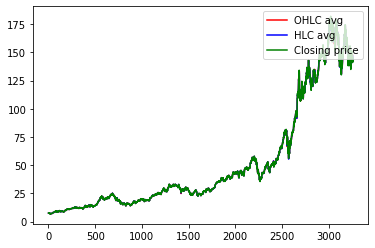

In [9]:
# 사용되는 지표들을 한번에 표시
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [10]:
# 시계열 데이터로 준비
scaler = MinMaxScaler(feature_range=(0, 1))

OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg), 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [11]:
# 준비된 시계열 Dataset을 Train Set과 Test Set으로 나눔 → Train : Test = 0.75 : 0.25
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# Dataset을 Feature와 Groundtruth로 분리
train_x, train_y = new_dataset(train_OHLC, 1)
test_x, test_y = new_dataset(test_OHLC, 1)

# Feature Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
step_size = 1

In [12]:
# 모델 생성, 객체로 생성하지 않음.
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [13]:
# 모델 컴파일, 모델 훈련
model.compile(loss='mean_squared_error', optimizer='adagrad')
model.fit(train_x, train_y, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
2443/2443 - 18s - loss: 0.0083 - 18s/epoch - 7ms/step
Epoch 2/5
2443/2443 - 9s - loss: 0.0057 - 9s/epoch - 4ms/step
Epoch 3/5
2443/2443 - 8s - loss: 0.0055 - 8s/epoch - 3ms/step
Epoch 4/5
2443/2443 - 8s - loss: 0.0055 - 8s/epoch - 3ms/step
Epoch 5/5
2443/2443 - 8s - loss: 0.0055 - 8s/epoch - 3ms/step


In [14]:
# 훈련과 검정 데이터의 예측 실시
train_p = model.predict(train_x)
test_p = model.predict(test_x)

26/26 [==============================] - 0s 2ms/step


In [15]:
# 예측된 데이터들을 반 정규화, 데이터의 단순성을 보장?
train_p = scaler.inverse_transform(train_p)
train_y = scaler.inverse_transform([train_y])

test_p = scaler.inverse_transform(test_p)
test_y = scaler.inverse_transform([test_y])

In [16]:
# 훈련 RMSE와 검정 RMSE 출력
train_score = math.sqrt(mean_squared_error(train_y[0], train_p[:,0]))
print('Train RMSE: %.2f' % (train_score))

test_score = math.sqrt(mean_squared_error(test_y[0], test_p[:,0]))
print('Test RMSE: %.2f' % (test_score))

Train RMSE: 12.88
Test RMSE: 105.00


In [17]:
# 훈련 데이터 예측에 대한 그래프 생성
train_p_plot = np.empty_like(OHLC_avg)
train_p_plot[:, :] = np.nan
train_p_plot[step_size : len(train_p) + step_size, :] = train_p

In [18]:
# 검정 데이터 예측에 대한 그래프 생성
test_p_plot = np.empty_like(OHLC_avg)
test_p_plot[:, :] = np.nan
test_p_plot[len(train_p) + (step_size * 2) + 1 : len(OHLC_avg) - 1, :] = test_p

In [19]:
# 메인 Dataset 반정규화
OHLC_avg = scaler.inverse_transform(OHLC_avg)

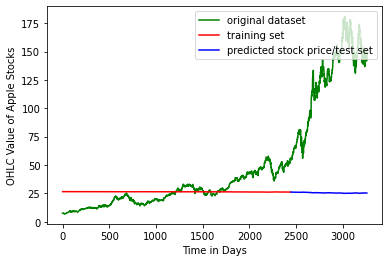

In [20]:
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(train_p_plot, 'r', label = 'training set')
plt.plot(test_p_plot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

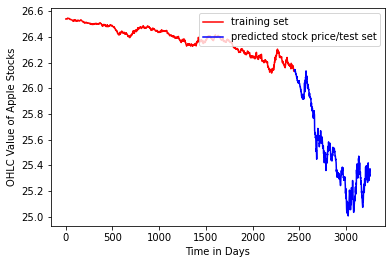

In [21]:
plt.plot(train_p_plot, 'r', label = 'training set')
plt.plot(test_p_plot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [37]:
last_val = test_p[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", last_val[0])
print("Next Day Value:", last_val[0] * next_val[0][0])

1/1 [==============================] - 0s 16ms/step
Last Day Value: 25.36324
Next Day Value: 2.6344514
